In [1]:
import pandas as pd
import numpy as np

Apply the Random Forests algorithm but this time only by upscaling the data.

In [5]:
categorical = pd.read_csv('files_for_lab/categorical.csv')
numerical = pd.read_csv('files_for_lab/numerical.csv')
target = pd.read_csv('files_for_lab/target.csv')

In [8]:
#encode the categoricals
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first').fit(categorical)
encoded_categorical = encoder.transform(categorical).toarray()
encoded_categorical = pd.DataFrame(encoded_categorical)

In [9]:
data = pd.concat([encoded_categorical, numerical, target], axis=1)

In [11]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,TARGET_B,TARGET_D
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,10.0,4,7.741935,95515,0,4,39,0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,25.0,18,15.666667,148535,0,2,1,0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,16.0,5.0,12,7.481481,15078,1,4,60,0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,10.0,9,6.812500,172556,1,4,41,0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,15.0,14,6.864865,7112,1,2,26,0,0.0


In [12]:
data.TARGET_B.value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

In [14]:
#upsample
from sklearn.utils import resample
majority_class = data[data.TARGET_B == 0]
minority_class = data[data.TARGET_B == 1]

minority_class_upsampled = resample(minority_class, 
                                   replace=True, 
                                   n_samples = len(majority_class))

data_upsampled = pd.concat([majority_class, minority_class_upsampled], axis=0)

In [15]:
data_upsampled.shape

(181138, 636)

In [124]:
#X-y split
y = data_upsampled['TARGET_B']
X = data_upsampled.drop(['TARGET_B'], axis=1)

#train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

y_train_regression = X_train['TARGET_D']
y_test_regression = X_test['TARGET_D']


X_train = X_train.drop(['TARGET_D'], axis = 1)
X_test = X_test.drop(['TARGET_D'], axis = 1)

In [71]:
#building the Random Forest classification model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20)

clf.fit(X_train, y_train)
print('train score: ',clf.score(X_train, y_train))
print('test score: ',clf.score(X_test, y_test))

train score:  0.6189703954178456
test score:  0.6155183835707188


In [28]:
#cross validation score
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))

0.6123524946518529


Discuss the output and its impact in the business scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the business?

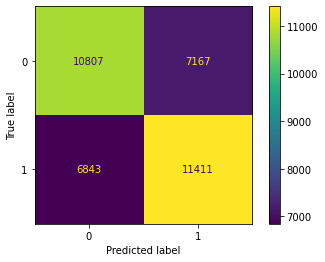

In [31]:
#confusion matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test)

The false positives are people that were predicted to donate but did not donate, and the false negatives are the people that were predicted to be non-donors but did actually donate. 

In this case if we only send the promotional mail to the predicted donors the cost of a false negative(missing out on a donation) is far more than the cost of a false positive(the cost of postage). 

It would be best to focus on minimizing the false negatives in order to increase total donation amount. We can lower the threshold for a positive prediction in order to increase the amount of positives predicted. The optimal donor probability threshold for maximum revenue would depend on the cost of postage of each promotional mail(not included in the case study) and the estimated donation amounts(which I will build a model to predict in the next lab).  

In [72]:
#adding predictions to dataset
y = X['TARGET_D']
X = X.drop(['TARGET_D'], axis=1)

pred = clf.predict(X)
pred_prob = clf.predict_proba(X)

X['predicted_donor'] = pred
X['predicted_donor_prob'] = [pred_prob[i][1] for i in range(len(pred_prob))]
donor_prediction_data = X.copy()
donor_prediction_data.head()

,0,1,2,3,4,5,6,7,8,9,...,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,predicted_donor,predicted_donor_prob
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,10.0,4,7.741935,95515,0,4,39,1,0.541511
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,25.0,18,15.666667,148535,0,2,1,0,0.489390
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,16.0,5.0,12,7.481481,15078,1,4,60,1,0.523430
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,10.0,9,6.812500,172556,1,4,41,1,0.546596
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,15.0,14,6.864865,7112,1,2,26,0,0.437591


# Lab | Final regression model in "Health Care for All" Case

At this point, we have created a model to predict who will make a donation and who won't. But, what about the ammount of money that each person will give? In this lab, subset those that made a donation and use that subset to create a model to predict how much money will they give.

In [126]:
#create subset of data for donors only using same train-test groups as classification model
train = pd.concat([X_train, y_train, y_train_regression], axis=1)
test = pd.concat([X_test, y_test, y_test_regression], axis=1)

donor_train = train[train['TARGET_B']==1]
donor_test = test[test['TARGET_B']==1]

#save nondonor data for later...
nondonor_train = train[train['TARGET_B']==0]
nondonor_test = test[test['TARGET_B']==0]
nondonor = pd.concat([nondonor_train, nondonor_test], axis=0)

#make train-test groups
y_train = donor_train['TARGET_D']
y_test = donor_test['TARGET_D']

X_train = donor_train.drop(['TARGET_D'], axis=1)
X_test = donor_test.drop(['TARGET_D'], axis=1)

In [ ]:
#building Random Forest regession model
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20)

rf.fit(X_train, y_train)
print('train score: ',rf.score(X_train, y_train))
print('test score: ',rf.score(X_test, y_test))
#cross validation score
cross_val_scores = cross_val_score(rf, X_train, y_train, cv=10)
print('cross validation score: ',np.mean(cross_val_scores))

train score:  0.6805368693135785
test score:  0.6479747704931379


In [81]:
#also trying a linear regression model

#scale features
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(X_train)
Xtrain_scaled = ss.transform(X_train)
Xtest_scaled  = ss.transform(X_test)

#fit and test model
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(Xtrain_scaled, y_train)
print('train score: ', lr.score(Xtrain_scaled, y_train))
print('test score: ', lr.score(Xtest_scaled, y_test))

#cross validation score
cross_val_scores = cross_val_score(lr, Xtrain_scaled, y_train, cv=10)
print('cross validation score: ',np.mean(cross_val_scores))

train score:  0.5955221862976307
test score:  0.599185182156494
cross validation score:  0.5869300386150983


In [ ]:
#The Random Forest scores are better, so I will use that model.

Evaluate the result of your model and estimate how much better the results are for the business in comparison with the naive scenario we discuss on Monday.

In the naive scenario everyone would receive the promotional mail. If we assume that each piece of promotional mail cost 68 cents(I did not see this in the case study documentation but was mentioned in class) and all 95412 potential donors were to receive one, that would cost the company $64880.16. The total amount of donations received was $75668.70, leaving $10788.54 in revenue. That revenue could be maximized by cutting some of the money spent on promotional mail by choosing to only send it to the predicted donors. As sending promotional mail has less cost than missing out on a potential donation it would be best to overpredict donors in order to minimize missed donations. 


With the predicted donation amounts we can find the optimal group of potential donors to send promotional mail to to maximize the revenue.

In [99]:
#adding the donor predictions to the dataset
prediction_data = data_upsampled.copy()
prediction_data['predicted_donor'] = donor_prediction_data['predicted_donor']
prediction_data['predicted_donor_prob'] = donor_prediction_data['predicted_donor_prob']

In [117]:
#add predicted donation amounts to dataset

#split into predicted donors and nondonors
p_donors = prediction_data[prediction_data['predicted_donor_prob']>=.5]
p_nondonors = prediction_data[prediction_data['predicted_donor_prob']<.5]

#drop target columns from predicted_donors dataset
temp = p_donors.drop(['TARGET_B', 'TARGET_D', 'predicted_donor', 'predicted_donor_prob'], axis=1)

#predict donation amounts and add to dataset
predicted_amounts = rf.predict(temp)
p_donors['predicted_amount'] = predicted_amounts

#concat dataset back together
prediction_data = pd.concat([p_donors, p_nondonors])

/var/folders/tg/qj8xd12d4kldbd9gnfgt88th0000gn/T/ipykernel_9263/2541388303.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_donors['predicted_amount'] = predicted_amounts


In [122]:
#fill null values in predicted_amount with 0
prediction_data['predicted_amount'] = prediction_data['predicted_amount'].fillna(0)

In [123]:
prediction_data

,0,1,2,3,4,5,6,7,8,9,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,TARGET_B,TARGET_D,predicted_donor,predicted_donor_prob,predicted_amount
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.741935,95515,0,4,39,0,0.0,1,0.541511,10.521388
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,7.481481,15078,1,4,60,0,0.0,1,0.523430,9.646649
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.812500,172556,1,4,41,0,0.0,1,0.546596,10.501257
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.642857,62117,1,1,53,0,0.0,1,0.516433,10.521388
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.200000,109359,1,3,38,0,0.0,1,0.539004,8.859190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.400000,43013,1,1,57,1,20.0,0,0.451680,0.000000
31517,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.400000,34836,1,2,52,1,15.0,0,0.473665,0.000000
70938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.000000,11991,0,2,33,1,25.0,0,0.425612,0.000000
75374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.500000,132508,1,2,48,1,10.0,0,0.430782,0.000000
